<a href="https://colab.research.google.com/github/sanatsj/agents-course/blob/main/BuildinganANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(42)

In [ ]:
df=pd.read_csv('fashion-mnist_train.csv.zip')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


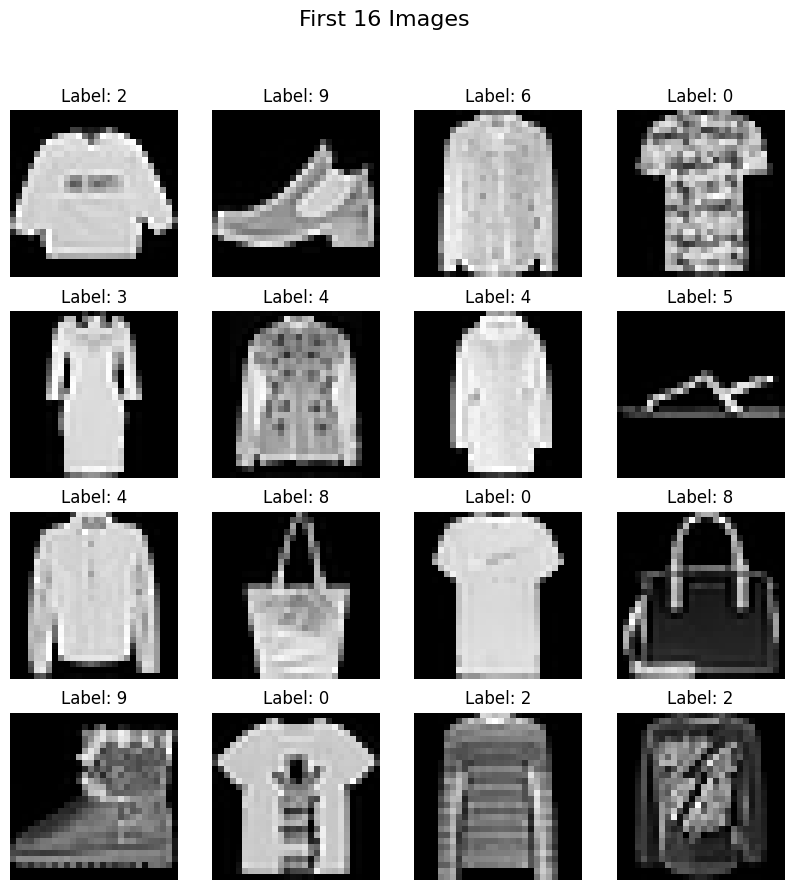

In [ ]:
#show first 16 images
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(10,10))
fig.suptitle("First 16 Images",fontsize=16)
for i,ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i,1:].values.reshape(28,28),cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.show()

In [ ]:
print(axes.flat)

In [ ]:
x=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
y_train

array([5, 7, 8, ..., 9, 4, 0])

In [ ]:
x_train=x_train/255.0

In [ ]:
x_test=x_test/255.0

In [ ]:
x_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [ ]:
x_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.82745098, 0.4       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
x_train.shape
print(isinstance(x_train, torch.Tensor))

False


In [ ]:
class customdataset(Dataset):
  def __init__(self,features,labels):
    self.feature = torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)
  def __len__(self):
    return len(self.feature)
  def __getitem__(self,idx):
    return self.feature[idx],self.labels[idx]

In [ ]:
train_dataset=customdataset(x_train,y_train)
test_dataset=customdataset(x_test,y_test)

In [ ]:
x_train.shape

(48000, 784)

In [ ]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [ ]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [ ]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.4 MB/s eta 0:00:00


In [ ]:
import optuna
study=optuna.create_study(direction='maximize')


[I 2025-04-21 20:01:22,359] A new study created in memory with name: no-name-4fb5755d-b5d7-40e1-877c-c604e18f4219


In [ ]:
study.optimize(objective,n_trials=10)

[I 2025-04-21 20:02:30,883] Trial 0 finished with value: 0.877 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 64, 'epochs': 40, 'learning_rate': 0.0032090904915031307, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 1.5085578040711815e-05}. Best is trial 0 with value: 0.877.
[I 2025-04-21 20:07:31,481] Trial 1 finished with value: 0.8793333333333333 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 80, 'epochs': 50, 'learning_rate': 0.0015002483233938246, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 3.392382170843949e-05}. Best is trial 1 with value: 0.8793333333333333.
[I 2025-04-21 20:11:40,767] Trial 2 finished with value: 0.8850833333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 128, 'epochs': 30, 'learning_rate': 0.00021262728883550598, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 3.510865577764819e-05}. Best is t

In [ ]:
study.best_value

0.8901666666666667